In [1]:
import matplotlib.pyplot as plt
import numpy
import concurrent.futures
from joblib import dump,load, Parallel, delayed, parallel_config

from tifffile import TiffFile,imread
from scipy.signal import find_peaks

In [2]:
import tensorstore as ts
def open_tensor(fpath, driver='zarr', store='file', AWS_param=None, bytes_limit= 100_000_000):
    """Open a tensorstore object.
       driver: Type of file, including zarr, n5, precomputed
       store: Type of source, including file, s3
       AWS_client: Only applicable to s3 store
    """
    kvstore = {"driver": store,"path": fpath}
    if store == 's3':
        bucket,path = split_s3_path(fpath)
        kvstore = {"driver": "s3","bucket": bucket ,"path": path}
        if AWS_param:
            kvstore.update({"aws_region": AWS_param.region})
            if hasattr(AWS_param, "endpoint_url"):
                kvstore.update({"endpoint": AWS_param.endpoint_url})
            cred = {"aws_credentials":{"profile": AWS_param.profile}}
            if hasattr(AWS_param, "credential_file"):
                cred = {"aws_credentials":{"profile": AWS_param.profile, 
                                           "filename": AWS_param.credential_file['filename']}}
            kvstore.update(cred)
    #Load tensorstore array
    dataset_future = ts.open({
         'driver':
             driver,
         'kvstore': kvstore,
     # Use 100MB in-memory cache.
         'context': {
             'cache_pool': {
                 'total_bytes_limit': bytes_limit
             }
             \
         },
         'recheck_cached_data':
         'open',
     })

    return dataset_future.result()

In [3]:
#Open image data and transpose
stack = open_tensor("/ACdata/Users/kevin/exaspim_ome_zarr/output_exa4/test.zarr/tile_x_0002_y_0001_z_0000_ch_488/4/", bytes_limit= 100_000_000)
stack = stack[0,0,:,:,:]

In [4]:
# Get information about the stack dimensions
num_slices, height, width = stack.shape
print(f"Number of slices: {num_slices}")
print(f"Image dimensions: {width}x{height}")

Number of slices: 384
Image dimensions: 888x672


In [6]:
stack_tmp = stack[:,:,:].read().result()
stack_tmp.shape

(384, 672, 888)

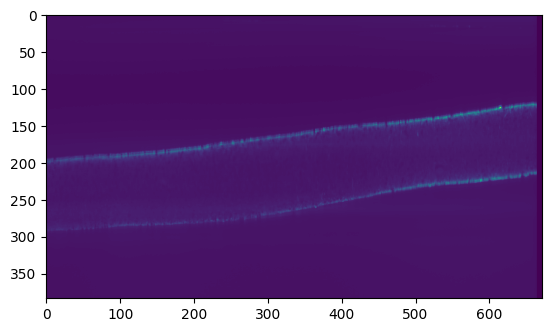

In [7]:
plt.imshow(stack_tmp[:,:,0])

In [8]:
# detect surface of the mip data
def detect_surface(mipdata):
    # detect surface
    surface = numpy.zeros((mipdata.shape[1],mipdata.shape[2]),dtype=numpy.int32)
    for i in range(mipdata.shape[1]):
        for j in range(mipdata.shape[2]):
            peaks, values = find_peaks(mipdata[:,i,j], prominence=100)
            if len(peaks) > 1:
                peaks = peaks[values['prominences'].argsort()[-2:]]
                surface[i,j] = numpy.round((peaks[0] + peaks[1]) / 2)
    return surface.astype(numpy.int32)

def compute_shifts(surface):
    # Compute shifts to flatten the surface
    reference_level = numpy.median(surface[surface > 0])
    # replace the zero values with the reference level
    surface[surface == 0] = reference_level.astype(int)

    shifts = surface - reference_level
    return shifts.astype(int)

def apply_shifts(data, shifts):
    flattened_data = numpy.zeros_like(data)
    for i in range(mipdata.shape[1]):
        for j in range(mipdata.shape[2]):
            shift = shifts[i, j]
            if shift < 0:
                flattened_data[-shift:, i, j] = mipdata[:shift, i, j]
            elif shift == 0:
                flattened_data[:, i, j] = mipdata[:, i, j]
            else:
                flattened_data[:-shift, i, j] = mipdata[shift:, i, j]
    return flattened_data

In [9]:
surface = detect_surface(stack_tmp)
surface.shape

(672, 888)

In [10]:
surface

array([[245, 244,   0, ..., 170, 169,   0],
       [  0,   0,   0, ..., 170, 169,   0],
       [  0, 246, 245, ..., 170, 170,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int32)

218.0

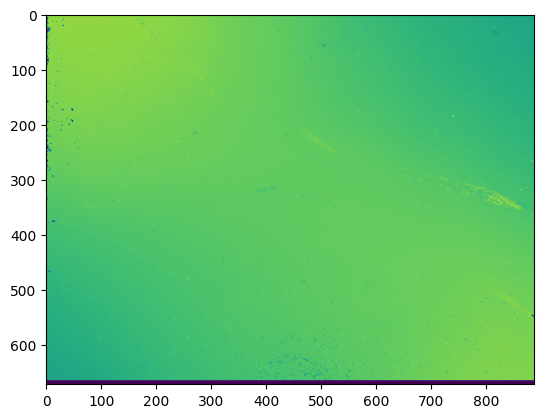

In [11]:
plt.imshow(surface)
numpy.median(surface)

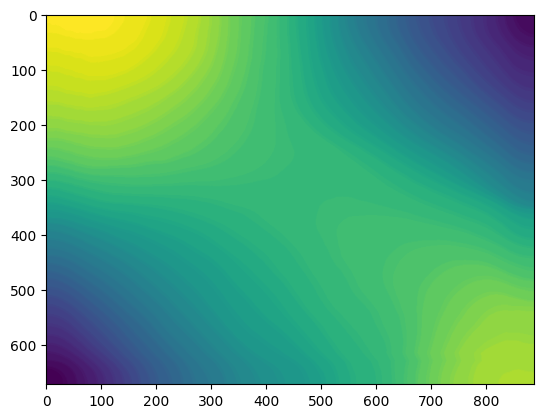

In [12]:
# smooth the surface with median filter
from scipy.ndimage import median_filter
surface_smooth = median_filter(surface, size=100)
plt.imshow(surface_smooth)


In [13]:
shifts = compute_shifts(surface_smooth)
shifts

array([[ 26,  26,  26, ..., -44, -44, -44],
       [ 26,  26,  26, ..., -44, -44, -44],
       [ 26,  26,  26, ..., -44, -44, -44],
       ...,
       [-46, -46, -46, ...,  17,  17,  17],
       [-46, -46, -46, ...,  17,  17,  17],
       [-46, -46, -46, ...,  17,  17,  17]])

In [23]:
# Calculate the mean intensity of each section
section_medians = np.median(stack, axis=(0, 1))

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(section_medians)
plt.title('Section Medians')
plt.xlabel('Section')
plt.ylabel('Median value')
plt.show()


In [7]:
# Calculate the mean intensity of each section
def z_mean_intensity(num,arr,z_slice):
    mean = np.median(arr[:,:,z_slice])
    return([num,mean])
    
slices = list(range(num_slices))
with parallel_config(backend="loky", inner_max_num_threads=1):
    %time res = Parallel(n_jobs=20)(delayed(z_mean_intensity)(num=num, arr=stack, z_slice=z_slice) for num,z_slice in enumerate(slices))
sorted(res)
section_medians = np.array([x[1] for x in res])

plt.figure(figsize=(10, 6))
plt.plot(section_medians)
plt.title('Section Medians')
plt.xlabel('Section')
plt.ylabel('Median value')
plt.show()

/home/wanqing.yu/anaconda3/envs/AC/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

NameError: name 'res' is not defined

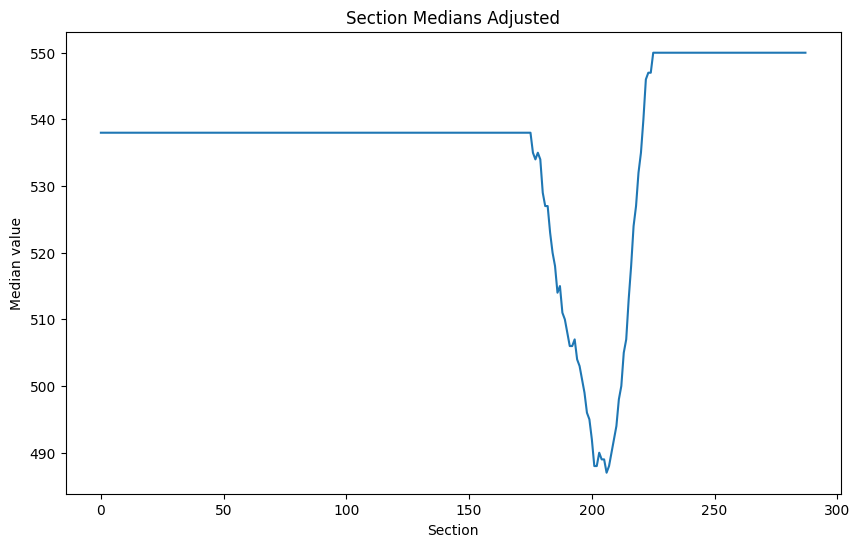

In [6]:
from scipy.signal import find_peaks

# Find peaks of the section_medians array
peaks, _ = find_peaks(section_medians, prominence=40)

section_medians_corrected = section_medians.copy()

# Apply peak value to the surface stacks
section_medians_corrected[0:peaks[0]] = section_medians[peaks[0]]
section_medians_corrected[peaks[-1]:] = section_medians[peaks[-1]]

plt.figure(figsize=(10, 6))
plt.plot(section_medians_corrected)
plt.title('Section Medians Adjusted')
plt.xlabel('Section')
plt.ylabel('Median value')
plt.show()

In [7]:
# Calculate the desired mean intensity (e.g., the min of section medians)
desired_median = np.min(section_medians_corrected)

# Normalize each section to the desired mean intensity
for i in range(stack.shape[2]):
    print(i)
    normalized_stack[:,:,z_slice].write(((stack[:,:,i].read().result() / section_medians_corrected[i]) * desired_median).astype('uint16')).result()

0


NameError: name 'normalized_stack' is not defined

In [ ]:
# Calculate the desired mean intensity (e.g., the min of section medians)
desired_median = np.min(section_medians_corrected)
normalized_stack = create_tensor("/ACdata/Users/connorl/Image_Files/normalized_stack.zarr", stack.shape, dtype = 'uint16', fill_value=0)

In [ ]:
# Normalize each section to the desired mean intensity
writes = []

for i in range(stack.shape[2]):
    writes.append(normalized_stack[:,:,i].write(((stack[:,:,i] / section_medians_corrected[i]) * desired_median).astype('uint16')))

for write in writes:
    write.result()  

In [ ]:
# Calculate the median intensity of normalized stack
slices = list(range(num_slices))
with parallel_config(backend="loky", inner_max_num_threads=1):
    %time res = Parallel(n_jobs=20)(delayed(z_mean_intensity)(num=num, arr=normalized_stack, z_slice=z_slice) for num,z_slice in enumerate(slices) )
sorted(res)
section_medians_normalized = np.array([x[1] for x in res])

plt.figure(figsize=(10, 6))
plt.plot(section_medians_normalized)
plt.title('Section Medians Normalized')
plt.xlabel('Section')
plt.ylabel('Median value')
plt.show()